In [3]:
import zipfile
import os
from datetime import datetime, timedelta
from collections import defaultdict

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings("ignore")


### Extract GTFS files for STM

In [2]:
GTFS_FILENAME = "gtfs_stm"
current_dir = os.getcwd()

zip_file_path = os.path.join(current_dir, GTFS_FILENAME + '.zip')
extract_folder_path = os.path.join(current_dir, GTFS_FILENAME)

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


### Load GTFS

In [4]:
stops = pd.read_csv(os.path.join(extract_folder_path, 'stops.txt'))
routes = pd.read_csv(os.path.join(extract_folder_path, 'routes.txt'))
trips = pd.read_csv(os.path.join(extract_folder_path, 'trips.txt'))
stop_times = pd.read_csv(os.path.join(extract_folder_path, 'stop_times.txt'))
calendar = pd.read_csv(os.path.join(extract_folder_path, 'calendar.txt'))

Remove night buses

In [5]:
# remove night buses
routes = routes[~routes['route_short_name'].between(300, 399)]

Remove 24 from times over 24, then convert to datetime

In [6]:
stop_times['stop_id'] = stop_times['stop_id'].astype(str)

st = stop_times['departure_time'].apply(lambda x:'0' + str(int(x[:2]) - 24) + x[2:] if int(x[:2]) > 23 else x)
stop_times['departure_time'] = pd.to_datetime(st)


Filter metro station stops and filter bus stops that have that have the word "Station" in them

In [7]:
metro_stops = stops[(stops['location_type'] == 0) & (stops['parent_station'].notna())]
bus_stops = stops[(stops['location_type'] == 0) & (stops['parent_station'].isna()) & stops['stop_name'].str.lower().str.startswith('station')]

Rename separated transfer stations per line by adding line as suffix

In [8]:
STOP_ID_LINE_DICT = {
    '9999111': ' (Verte)',
    '9999112': ' (Orange)',
    '9999114': ' (Jaune)',
    '9999492': ' (Orange)',
    '9999495': ' (Bleue)',
    '9999052': ' (Orange)',
    '9999055': ' (Bleue)',
}


metro_stops['stop_name'] = metro_stops.apply(lambda row: row['stop_name'] + STOP_ID_LINE_DICT.get(row['stop_id'], ''), axis = 1)

### Helper functions to match metro stations to the nearest bus stops

In [9]:
NEARBY_BUS_STOP_RADIUS = 0.002
def get_trip_times_per_stop(stop_ids):
    """
    Merge datasets to return a more detailed timetable:
    | stop_id | departure_time | stop_sequence | route_short_name | service_id | direction_id |
    """
    filtered_stop_times = stop_times[stop_times['stop_id'].isin(stop_ids)]
    stop_times_with_trips = filtered_stop_times.merge(trips, on='trip_id', how='left')
    final_table = stop_times_with_trips.merge(routes, on='route_id', how='left')
    final_table = final_table[['stop_id', 'departure_time', 'stop_sequence', 
                            'route_short_name', 'service_id', 'direction_id']]
    return final_table


def match_bus_to_metro(metro_stops, bus_stops, max_distance = NEARBY_BUS_STOP_RADIUS):
    """
    With the help of ChatGPT.
    Using shapely and GeoPandas to match each metro stop to multiple nearby bus stops.
    NEARBY_BUS_STOP_RADIUS = 0.002 = 200m is the radius
    """
    metro_stops['geometry'] = [Point(xy) for xy in zip(metro_stops['stop_lon'], metro_stops['stop_lat'])]
    bus_stops['geometry'] = [Point(xy) for xy in zip(bus_stops['stop_lon'], bus_stops['stop_lat'])]
    gdf_a = gpd.GeoDataFrame(metro_stops, geometry='geometry')
    gdf_b = gpd.GeoDataFrame(bus_stops, geometry='geometry')

    # Create spatial index for group B
    spatial_index = gdf_b.sindex

    # Find matches for each point in group A
    matches = []
    for i, point in gdf_a.iterrows():
        possible_matches_index = list(spatial_index.intersection(point.geometry.buffer(max_distance).bounds))
        possible_matches = gdf_b.iloc[possible_matches_index]
        for j, match_point in possible_matches.iterrows():
            if point.geometry.distance(match_point.geometry) <= max_distance:
                matches.append({
                    'station_id': point['stop_id'],  # Replace 'id' with a unique identifier if available
                    'stop_id': match_point['stop_id'],
                    'distance': point.geometry.distance(match_point.geometry),
                    'station id': point['stop_id'],
                    'station name': point['stop_name'],
                    'stop id': match_point['stop_id'],
                    'stop name': match_point['stop_name'],

                })

    matches_df = pd.DataFrame(matches)
    return matches_df


### Preprocess GTFS to create detailed timetables

Create bus and metro timetables

In [10]:
bus_timetables = get_trip_times_per_stop(bus_stops['stop_id'])
metro_timetables = get_trip_times_per_stop(metro_stops['stop_id'])

Match metro stations to nearby bus stops and create metro->bus and bus->metro maps

In [11]:
metro_to_bus_df = match_bus_to_metro(metro_stops, bus_stops)
bus_metro_map = dict(zip(metro_to_bus_df['stop_id'], metro_to_bus_df['station_id']))
metro_bus_map = metro_to_bus_df.groupby('station_id')['stop_id'].apply(list).to_dict()

###  Definition of functions to extract results from the timetables

Extract weekday services within the same period to make sure we are comparing services that operate the same day.

In [13]:
weekday_services = calendar[calendar.iloc[:,1:6].prod(axis=1).apply(bool)]
weekday_services = weekday_services[(weekday_services['start_date']>=20240826) & (weekday_services['end_date']<=20241025)]
weekday_service_list = weekday_services['service_id'].tolist()

#### Functions that output result DataFrames

In [14]:
METRO_DIRECTION_MAPPING = {
    2: {
        0: '-> Station Montmorency',
        1: '-> Station Côte-Vertu',
    },
    1: {
        0: '-> Station Honoré-Beaugrand',
        1: '-> Station Angrignon',
    },
    4: {
        0: '-> Station Berri-UQAM',
        1: '-> Station Longueuil-Université de Sherbrooke',
    },
    5: {
        0: '-> Station Saint-Michel',
        1: '-> Station Snowdon',
    },
}

In [15]:
MIN_DEPARTURE_COUNT = 10
MIN_MATCH_DATA_SIZE = 10
def get_time_diff_df_for_station(metro_stop_id, restrict_to_first_stop):
    """
    This is the main function of this notebook. It utilizes all the functions below it.
    """
    metro = metro_timetables[metro_timetables['stop_id'] == metro_stop_id].sort_values('departure_time')
    metro = metro[metro['service_id'].isin(weekday_service_list)]

    if metro_bus_map.get(metro_stop_id) is None:
        print('---> No bus seems to pass from this station')
        return None, None, None, None

    bus = bus_timetables[bus_timetables['stop_id'].isin(metro_bus_map.get(metro_stop_id))].sort_values('departure_time')
    if restrict_to_first_stop:
        bus = bus[bus['stop_sequence'] == 1]
    bus.dropna(subset='route_short_name', inplace=True)
    bus['route_short_name'] = bus['route_short_name'].astype(int)
    bus = bus[bus['service_id'].isin(weekday_service_list)]
    
    if len(bus) == 0:
        print('---> No buses seem to depart from this station')
        return None, None, None, None
    if len(bus) < MIN_DEPARTURE_COUNT:
        print('---> Not enough first stop departures, only {}'.format(len(bus)))
        return None, None, None, None

    metro_bus_matches = get_closest_bus_departure_to_metro_stop_time(metro['departure_time'], bus)
    metro_bus_matches = process_metro_bus_departure_matches(metro_bus_matches, bus, metro)
    
    metro_bus_match_per_bus_dir = get_closest_bus_departure_to_metro_stop_time_per_bus_and_direction(metro['departure_time'], bus)
    metro_bus_match_per_bus_dir = {
        (bus_route, bus_dir): process_metro_bus_departure_matches(
            v, bus[(bus['route_short_name'] == bus_route) & (bus['direction_id'] == bus_dir)], metro
        )
        for (bus_route, bus_dir), v in metro_bus_match_per_bus_dir.items()
    }

    return metro, bus, metro_bus_matches, metro_bus_match_per_bus_dir


def process_metro_bus_departure_matches(metro_bus_matches, bus_departures, metro_departures):
    """
    Takes the result of get_closest_bus_departure_to_metro_stop_time... and processes it:
    - Creates a time_diff, bus_route_short_name column and bus_direction_id columns
    - Uses get_next_departure to create a next_same_bus_departure column
    - Creates a wait_time_till_next_departure = next_same_bus_departure - closest_bus_departure_time + time_diff column
    """
    metro_bus_matches['time_diff'] = (
        metro_bus_matches['closest_bus_departure_time'] - metro_bus_matches['metro_departure_time']
        ).dt.total_seconds()
    
    metro_bus_matches['bus_route_short_name'] = metro_bus_matches['bus_index'].apply(lambda x: bus_departures.iloc[x]['route_short_name'])
    metro_bus_matches['bus_direction_id'] = metro_bus_matches['bus_index'].apply(lambda x: bus_departures.iloc[x]['direction_id'])
    metro_bus_matches['metro_direction_id'] = metro_bus_matches['metro_index'].apply(lambda x: metro_departures.iloc[x]['direction_id'])
    metro_bus_matches['next_same_bus_departure'] = metro_bus_matches.apply(lambda row: get_next_departure(row, bus_departures), axis=1)
    metro_bus_matches['wait_time_till_next_departure'] = (
        metro_bus_matches['next_same_bus_departure'] - metro_bus_matches['closest_bus_departure_time']
        ).dt.total_seconds() + metro_bus_matches['time_diff']
    
    return metro_bus_matches


def get_next_departure(row, bus_departures):
    """
    Get the next departure of the same bus and direction.
    - Input:
    row: each row of the metro & bus departure matches DataFrame
    bus_departures: a DataFrame of bus departures
    - Output: the next bus departure of the same route and direction after the closest bus departure in row
    """
    departure_time = bus_departures.iloc[row.bus_index]['departure_time']
    df = bus_departures[(bus_departures['route_short_name'] == row.bus_route_short_name) & (bus_departures['direction_id'] == row.bus_direction_id)]
    ind = np.where(df['departure_time'] == departure_time)[0][0]
    #ind = df.index.get_loc(bus_departures[bus_departures['departure_time'] == departure_time].name)
    try:
        return df.iloc[ind + 1]['departure_time']
    except:
        return df.iloc[0]['departure_time'] + timedelta(days=1)


def get_closest_bus_departure_to_metro_stop_time(metro, bus):
    """
    Uses binary_search_closest_datetime to get the closest bus departure for each metro departure

    - Input:
    metro: all metro departures for a station
    bus: all bus departures near a station
    - Output: a DataFrame of matches, containing the new column "closest_bus_departure_time"
    """
    res = []
    for metro_ind, metro_time in enumerate(metro.tolist()):
        bus_index, bus_time = binary_search_closest_datetime(bus['departure_time'].tolist(), metro_time)
        if bus_index is None:
            continue
        res.append((metro_ind, metro_time, bus_index, bus_time))
    df =  pd.DataFrame(res, columns=['metro_index', 'metro_departure_time', 'bus_index', 'closest_bus_departure_time'])
    return df.dropna(subset='closest_bus_departure_time')
        

def get_closest_bus_departure_to_metro_stop_time_per_bus_and_direction(metro, bus):
    """
    Uses binary_search_closest_datetime to get the closest bus departure for each metro departure

    - Input:
    metro: all metro departures for a station
    bus: all bus departures near a station
    - Output: a dictionary with keys being tuples of (route, direction_id) and the values being a DataFrame of matches filtered
    for departure only for (route, direction_id)containing the new column "closest_bus_departure_time".
    """
    res_dict = dict()
    connecting_buses = list(set(zip(bus['route_short_name'], bus['direction_id']))) 
    for bus_route, bus_dir in connecting_buses:
        res = []
        bus_subset = bus[(bus['route_short_name'] == bus_route) & (bus['direction_id'] == bus_dir)]
        for metro_ind, metro_time in enumerate(metro.tolist()):
            bus_index, bus_time = binary_search_closest_datetime(bus_subset['departure_time'].tolist(), metro_time)
            if bus_index is None:
                continue
            res.append((metro_ind, metro_time, bus_index, bus_time))
        df =  pd.DataFrame(res, columns=['metro_index', 'metro_departure_time', 'bus_index', 'closest_bus_departure_time'])
        df.dropna(subset='closest_bus_departure_time', inplace=True)
        if len(df) == 0:
            continue
        res_dict[(bus_route, bus_dir)] = df
    return res_dict


ACCEPTABLE_NEXT_BUS_DEPARTURE_DIFFERENCE = 180
MAX_DEPARTURE_WAIT_TIME = 30 * 60
def binary_search_closest_datetime(sorted_datetimes, target):
    """
    Uses binary search to quickly get the first bus departure that happens AFTER a metro departure.
    If we want a specific bus route, we fitler sorted_datetimes beforehand

    - Bus depatures before the metro departure are disregarded
    - If there is abus departure that happens 3mins (ACCEPTABLE_NEXT_BUS_DEPARTURE_DIFFERENCE) after the closest one,
    we chose the second departure. This is done because a headway of 3mins is okay and should not be considered as "missing a bus".
    - If the closest bus departure is in more than 30mins (MAX_DEPARTURE_WAIT_TIME), we assume that there is no upcoming departure
    after the metro. We do this to disregard bus departures that happen a long time after the train stops.
    30mins is not a reasonable waiting time in Montreal during the weekday.

    - Input:
    sorted_datetimes: a list of sorted bus departures related to the station
    target: The metro departure in question

    - Output:
    closest_index of the bus, from sorted_datimes, and the value associated with the index
    """
    # Do not match to entirely previous departures
    if (sorted_datetimes[-1] - target).total_seconds() < 0:
        return None, None
    left, right = 0, len(sorted_datetimes) - 1
    closest_index = -1
    min_diff = float('inf')

    while left <= right:
        mid = (left + right) // 2
        current_datetime = sorted_datetimes[mid]
        
        current_diff = (current_datetime - target).total_seconds()
        if current_diff < 0:
            left = mid + 1
            continue
        if abs(current_diff) < min_diff:
            min_diff = abs(current_diff)
            closest_index = mid

        if current_datetime < target:
            left = mid + 1
        else:
            right = mid - 1
    ## If the next departure is after more than 30 minutes, return None
    if (sorted_datetimes[closest_index] - target).total_seconds() > MAX_DEPARTURE_WAIT_TIME:
        return None, None
    ## If the departure after the next one is just 3 minutes away, then we choose that one!!
    if closest_index != len(sorted_datetimes) - 1:
        if (sorted_datetimes[closest_index + 1] - target).total_seconds() == ACCEPTABLE_NEXT_BUS_DEPARTURE_DIFFERENCE:
            return closest_index + 1, sorted_datetimes[closest_index + 1]
    return closest_index, sorted_datetimes[closest_index]

#### Functions that aggregate and plot the results

In [16]:
#### "Bus - Metro" latency distribution
def plot_latency_distribution(metro_bus_matches, station_name, suppress_output=False, suffix = ''):
    sns.histplot(metro_bus_matches['time_diff'], kde=True, bins=50, color="skyblue")
    plt.xlabel("s")
    plt.ylabel("Frequency")
    plt.title("Distribution of latency minutes for {}".format(station_name))
    output_path = os.path.join(current_dir, 'output')
    output_path = os.path.join(output_path, station_name)
    os.makedirs(output_path, exist_ok=True)
    plt.savefig(os.path.join(output_path, "Bus latency{}.png".format(suffix)), bbox_inches="tight")
    if suppress_output:
        plt.close()


#### Probability of missing bus assuming a station exit time of 3 minutes
EXIT_TIME = 180
def get_proba_missing_bus(df, station_exit_time=EXIT_TIME):
    return round((df < EXIT_TIME).mean(), 4)

#### Offending buses
def get_offending_bus_count_for_station(df, station_exit_time=EXIT_TIME):
    return df[df['time_diff'] < EXIT_TIME].drop_duplicates(
        subset = ['bus_route_short_name', 'closest_bus_departure_time']
    )['bus_route_short_name'].value_counts()


#### Evolution of the probability throughout the day
def get_proba_missing_bus_daily(metro_bus_matches, station_name, suppress_output=False, suffix = ''):
    probability_values = dict()
    for h in range(22):
        probability_values[(h, h + 1)] = get_proba_missing_bus(
            metro_bus_matches[
                metro_bus_matches['metro_departure_time'].dt.hour.isin(range(h, h + 1))
            ]['time_diff']
        )
    plt.figure(figsize=(5, 3))
    plt.plot([(2*h+1) / 2 for h, _ in probability_values.keys()], probability_values.values(), marker='o', color='b', linestyle='-')
    plt.xlabel("Time of Day (Hours)")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.title("Probability of missing bus (latency less than 3 minutes) over times of Day, {}".format(station_name))
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(current_dir, 'output')
    output_path = os.path.join(output_path, station_name)
    os.makedirs(output_path, exist_ok=True)
    plt.savefig(os.path.join(output_path, "Daily bus latency{}.png".format(suffix)), bbox_inches="tight")
    if suppress_output:
        plt.close()
    return probability_values


def get_proba_missing_bus_daily_per_metro_direction(metro_bus_matches, station_name, metro_short_name, suppress_output=False, suffix = ''):
    probability_values = defaultdict(dict)
    for dir in [0, 1]:
        metro_bus_matches_subset = metro_bus_matches[metro_bus_matches['metro_direction_id'] == dir]
        for h in range(22):
            probability_values[dir][(h, h + 1)] = get_proba_missing_bus(
                metro_bus_matches_subset[
                    metro_bus_matches_subset['metro_departure_time'].dt.hour.isin(range(h, h + 1))
                ]['time_diff']
            )
    plt.figure(figsize=(5, 3))
    plt.plot([(2*h+1) / 2 for h, _ in probability_values[0].keys()], probability_values[0].values(), marker='o', color='blue', linestyle='-')
    plt.plot([(2*h+1) / 2 for h, _ in probability_values[1].keys()], probability_values[1].values(), marker='o', color='orange', linestyle='-')
   
    plt.legend([METRO_DIRECTION_MAPPING[metro_short_name][0], METRO_DIRECTION_MAPPING[metro_short_name][1]])
    plt.xlabel("Time of Day (Hours)")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.title("Probability of missing bus (latency less than 3 minutes) over times of Day, {}".format(station_name))
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(current_dir, 'output')
    output_path = os.path.join(output_path, station_name)
    os.makedirs(output_path, exist_ok=True)
    plt.savefig(os.path.join(output_path, "Daily bus latency{} per metro direction.png".format(suffix)), bbox_inches="tight")
    if suppress_output:
        plt.close()
    return probability_values


# get average wait time till next departure for a station
def get_average_wait_time_for_next_departure(metro_bus_matches, station_exit_time=EXIT_TIME):
    wait_time_df = metro_bus_matches[metro_bus_matches['time_diff'] < EXIT_TIME]['wait_time_till_next_departure']
    if len(wait_time_df) == 0:
        return None
    return round(wait_time_df.mean())


# Plot wait times till next departure for a station
def plot_wait_times_for_next_departure(metro_bus_matches, station_name, suppress_output=False, suffix = ''):
    df = metro_bus_matches[metro_bus_matches['time_diff'] < EXIT_TIME]
    sns.histplot(
        df['wait_time_till_next_departure'].clip(upper=df['wait_time_till_next_departure'].quantile(0.95))
    , kde=True, bins=50, color="skyblue")

    plt.xlabel("s")
    plt.ylabel("Wait time")
    plt.title("Wait time till next departure for {}".format(station_name))
    output_path = os.path.join(current_dir, 'output')
    output_path = os.path.join(output_path, station_name)
    os.makedirs(output_path, exist_ok=True)
    plt.savefig(os.path.join(output_path, "Wait time for next departure{}.png".format(suffix)), bbox_inches="tight")
    if suppress_output:
        plt.close()



#### Function that iterates across all stations

In [17]:
def get_data_for_all_stations(restrict_to_first_stop=True):
    """
    - Input:
    restrict_to_first_stop:
        - True: Only consider buses that start at the station
        - False: Consider buses that either start or pass through the station (a more relaxed approach with a disregard for RT perturbations)
    """
    cols, values = [], []
    buses = []
    proba_missing_per_station_bus_dir = dict()
    daily_proba_missing_per_station_bus_dir = dict()
    daily_proba_missing_per_station_bus_dir_metro_dir = dict()
    for metro_stop_id in metro_stops['stop_id'].unique().tolist():
        station_name = metro_stops[metro_stops['stop_id'] == metro_stop_id]['stop_name'].tolist()[0]
        print(station_name)
        metro, bus, metro_bus_matches, metro_bus_match_bus_dir = get_time_diff_df_for_station(metro_stop_id, restrict_to_first_stop)
        if metro is None:
            continue

        suffix = '_relaxed' if restrict_to_first_stop else ''

        plot_latency_distribution(metro_bus_matches, station_name, suppress_output=True, suffix = suffix)
        proba = get_proba_missing_bus(abs(metro_bus_matches['time_diff']))
        proba_missing_per_station_bus_dir[station_name] = {
            k: get_proba_missing_bus(abs(v['time_diff'])) for k, v  in metro_bus_match_bus_dir.items()
        }

        daily_proba = get_proba_missing_bus_daily(metro_bus_matches, station_name, suppress_output=True, suffix = suffix)
        daily_proba_missing_per_station_bus_dir[station_name] = {
            k: get_proba_missing_bus_daily(
                v, station_name, suppress_output=True, suffix = suffix
            ) for k, v  in metro_bus_match_bus_dir.items()
        }
        metro_short_name = metro['route_short_name'].iloc[0]
        daily_proba_missing_per_station_bus_dir_metro_dir[station_name] = {
                    k: get_proba_missing_bus_daily_per_metro_direction(
                        v, station_name, metro_short_name, suppress_output=True, suffix = suffix
                    ) for k, v  in metro_bus_match_bus_dir.items()
        }

        avg_time = get_average_wait_time_for_next_departure(metro_bus_matches)

        plot_wait_times_for_next_departure(metro_bus_matches, station_name, suppress_output=True, suffix = suffix)

        buses.append(get_offending_bus_count_for_station(metro_bus_matches, station_exit_time=EXIT_TIME))

        values.append([metro_stop_id, station_name, proba, avg_time] + list(daily_proba.values()))

    cols = ['metro_stop_id', 'station_name', 'probability', 'avg wait time (s)'] + ['{}-{}'.format(begin, end) for (begin, end) in daily_proba.keys()]

    proba_df = pd.DataFrame(values, columns=cols)
    bus_df = pd.concat(buses)
    bus_df = pd.DataFrame(bus_df.groupby(bus_df.index).sum().sort_values(ascending=False)).reset_index()
    bus_df['bus_route_short_name'] = bus_df['bus_route_short_name'].apply(lambda x: 'Bus ' + str(x))
    return proba_df, bus_df, proba_missing_per_station_bus_dir, daily_proba_missing_per_station_bus_dir, daily_proba_missing_per_station_bus_dir_metro_dir

### Analysis of bus departures from metro stations

#### Buses that start from the stations only

In [18]:
(proba_df, bus_df, proba_missing_per_station_bus_dir, daily_proba_missing_per_station_bus_dir,
 daily_proba_missing_per_station_bus_dir_metro_dir) = get_data_for_all_stations()

Station Angrignon
Station Monk
---> No buses seem to depart from this station
Station Jolicoeur
Station Verdun
---> No buses seem to depart from this station
Station De l'Église
Station LaSalle
Station Charlevoix
Station Lionel-Groulx
Station Atwater
---> No buses seem to depart from this station
Station Guy-Concordia
Station Peel
---> No buses seem to depart from this station
Station McGill
Station Place-des-Arts
Station Saint-Laurent
---> No buses seem to depart from this station
Station Berri-UQAM (Verte)
Station Berri-UQAM (Orange)
Station Berri-UQAM (Jaune)
Station Beaudry
---> No buses seem to depart from this station
Station Papineau
Station Frontenac
Station Préfontaine
Station Joliette
Station Pie-IX
Station Viau
Station Assomption
Station Cadillac
Station Langelier
Station Radisson
Station Honoré-Beaugrand
Station Côte-Vertu
Station Du Collège
Station De la Savane
---> No buses seem to depart from this station
Station Namur
Station Plamondon
---> Not enough first stop departu

In [19]:
proba_df.sort_values('probability', ascending=False).head()

,metro_stop_id,station_name,probability,avg wait time (s),0-1,1-2,2-3,3-4,4-5,5-6,...,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22
23,65,Station Côte-Vertu,0.6870,2107,0.4545,0.0,NaN,NaN,NaN,0.8000,...,0.350,0.70,0.8000,0.8571,0.8158,0.8056,0.8966,0.6818,0.4500,0.50
42,1,Station Henri-Bourassa,0.5882,1159,0.3333,0.0,NaN,NaN,NaN,0.3333,...,0.600,0.40,0.7500,0.6154,0.7692,0.7297,0.6207,0.5000,0.4000,0.65
22,18,Station Honoré-Beaugrand,0.5832,1262,0.2308,0.0,NaN,NaN,NaN,0.2000,...,0.450,0.50,0.7000,0.7037,0.8889,0.8205,0.5667,0.3636,0.3684,0.45
5,36,Station Lionel-Groulx,0.5543,2150,0.2692,0.0,NaN,NaN,NaN,0.4444,...,0.625,0.70,0.5250,0.6415,0.7067,0.6974,0.6724,0.4091,0.3750,0.40
0,43,Station Angrignon,0.5357,1314,0.4615,1.0,NaN,NaN,NaN,0.6000,...,0.500,0.55,0.5714,0.4815,0.6486,0.6486,0.5517,0.3913,0.4737,0.35


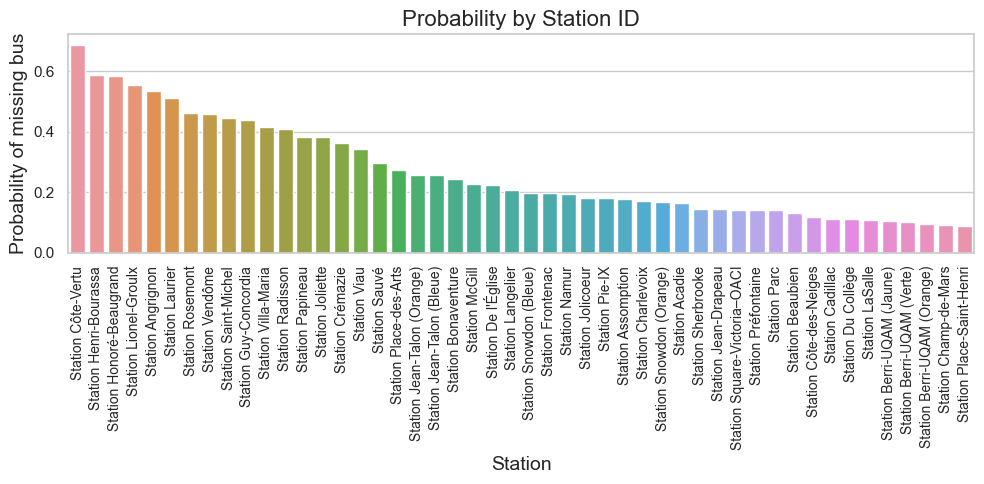

In [20]:
plt.figure(figsize=(10, 5))
sns.barplot(x='station_name', y='probability', data=proba_df.sort_values('probability', ascending=False))

plt.title("Probability by Station ID", fontsize=16)
plt.xlabel("Station", fontsize=14)
plt.ylabel("Probability of missing bus", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

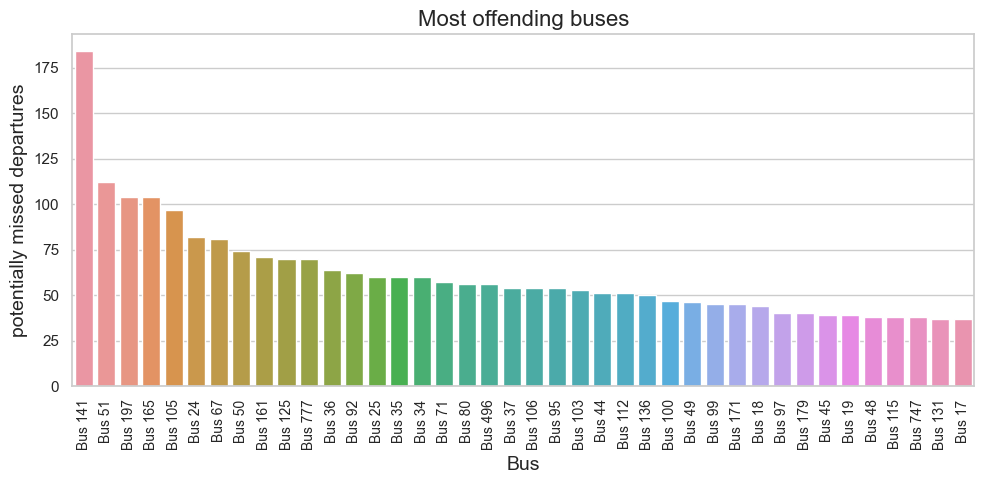

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(x='bus_route_short_name', y='count', data=bus_df.sort_values('count', ascending=False).iloc[:40])

plt.title("Most offending buses", fontsize=16)
plt.xlabel("Bus", fontsize=14)
plt.ylabel("potentially missed departures", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

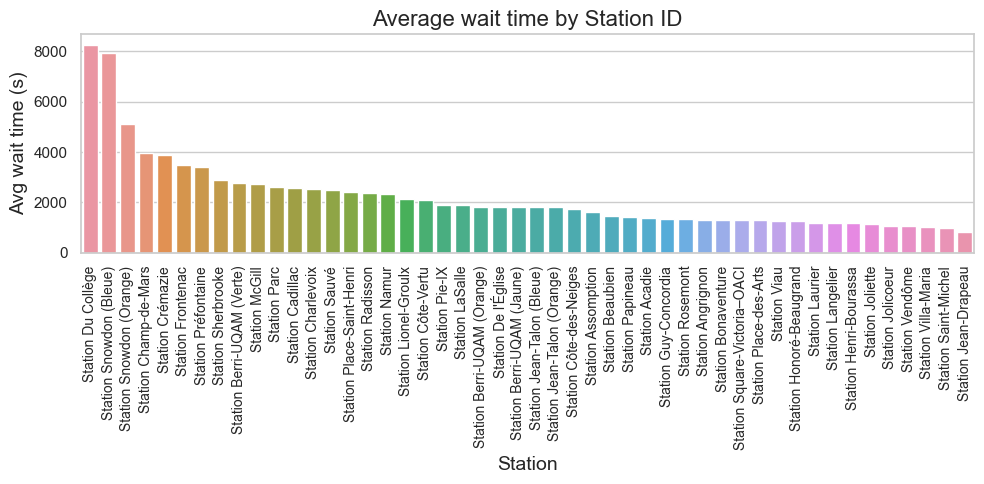

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(x='station_name', y='avg wait time (s)', data=proba_df.sort_values('avg wait time (s)', ascending=False))

plt.title("Average wait time by Station ID", fontsize=16)
plt.xlabel("Station", fontsize=14)
plt.ylabel("Avg wait time (s)", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
proba_missing_per_station_bus_dir['Station Rosemont']

{(161, 1): 0.3054,
 (13, 0): 0.105,
 (31, 0): 0.1118,
 (197, 0): 0.187,
 (25, 1): 0.1158}

#### Buses that start from or pass through the stations only (relaxed version of departures)

In [25]:
(proba_df_relaxed, bus_df_relaxed, proba_missing_per_station_bus_dir_relaxed, daily_proba_missing_per_station_bus_dir_relaxed,
 daily_proba_missing_per_station_bus_dir_metro_dir_relaxed) = get_data_for_all_stations(restrict_to_first_stop=False)

Station Angrignon
Station Monk
Station Jolicoeur
Station Verdun
Station De l'Église
Station LaSalle
Station Charlevoix
Station Lionel-Groulx
Station Atwater
Station Guy-Concordia
Station Peel
Station McGill
Station Place-des-Arts
Station Saint-Laurent
Station Berri-UQAM (Verte)
Station Berri-UQAM (Orange)
Station Berri-UQAM (Jaune)
Station Beaudry
---> No buses seem to depart from this station
Station Papineau
Station Frontenac
Station Préfontaine
Station Joliette
Station Pie-IX
Station Viau
Station Assomption
Station Cadillac
Station Langelier
Station Radisson
Station Honoré-Beaugrand
Station Côte-Vertu
Station Du Collège
Station De la Savane
Station Namur
Station Plamondon
Station Côte-Sainte-Catherine
Station Snowdon (Orange)
Station Snowdon (Bleue)
Station Villa-Maria
Station Vendôme
Station Place-Saint-Henri
Station Georges-Vanier
---> No bus seems to pass from this station
Station Lucien-L'Allier
---> No bus seems to pass from this station
Station Bonaventure
Station Square-Victo

In [26]:
proba_df_relaxed

,metro_stop_id,station_name,probability,avg wait time (s),0-1,1-2,2-3,3-4,4-5,5-6,...,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22
0,43,Station Angrignon,0.8403,1492,0.6154,0.5,NaN,NaN,NaN,0.6000,...,0.7000,0.7500,0.7143,0.9259,0.9730,0.9189,0.8276,0.8696,0.6842,0.9000
1,42,Station Monk,0.1371,1775,NaN,NaN,NaN,NaN,NaN,0.0000,...,0.1000,0.1000,0.1500,0.1111,0.1622,0.2105,0.2069,0.1739,0.1000,0.0526
2,41,Station Jolicoeur,0.4114,1293,0.1667,0.5,NaN,NaN,NaN,0.2500,...,0.2000,0.3500,0.3500,0.4815,0.5135,0.5946,0.4138,0.4348,0.2500,0.3000
3,40,Station Verdun,0.2905,1126,0.1667,0.0,NaN,NaN,NaN,0.0000,...,0.2000,0.2500,0.2500,0.3077,0.3514,0.4872,0.3103,0.0909,0.1500,0.2500
4,39,Station De l'Église,0.5924,1432,0.2857,0.0,NaN,NaN,NaN,1.0000,...,0.7000,0.7000,0.7000,0.6667,0.5789,0.6486,0.4333,0.7727,0.5789,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,Station Parc,0.4585,1990,0.2857,NaN,NaN,NaN,NaN,0.5000,...,0.3125,0.3529,0.2500,0.4000,0.4583,0.5000,0.6190,0.6667,0.3333,0.2632
61,61,Station De Castelnau,0.3184,969,0.1000,NaN,NaN,NaN,NaN,0.2857,...,0.5000,0.4118,0.2941,0.3478,0.3200,0.5833,0.4000,0.4211,0.1053,0.2222
62,62,Station Fabre,0.3969,911,0.3077,NaN,NaN,NaN,NaN,0.1429,...,0.3750,0.2941,0.3125,0.4167,0.6000,0.4000,0.6500,0.2778,0.1111,0.3158
63,63,Station D'Iberville,0.3411,1114,0.3077,NaN,NaN,NaN,NaN,0.1429,...,0.2778,0.2500,0.3125,0.2917,0.4800,0.3750,0.5238,0.3889,0.2222,0.3000


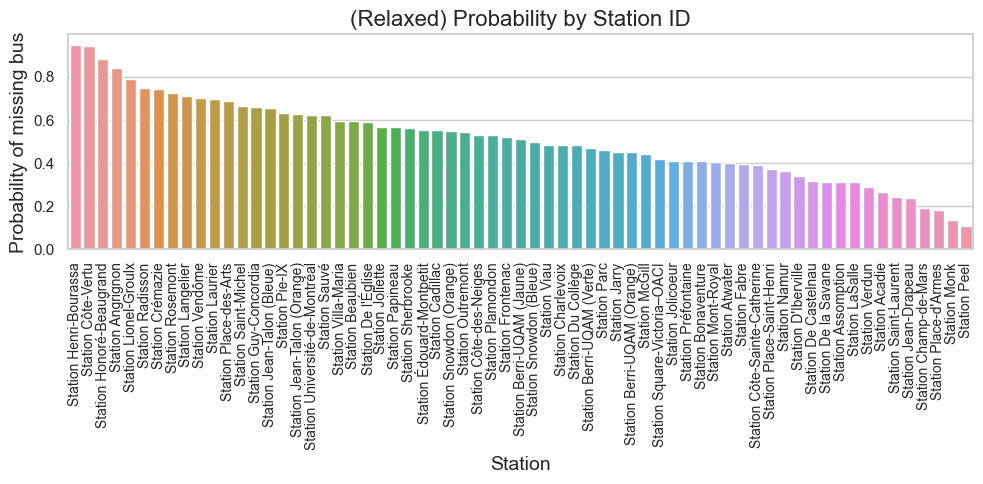

In [27]:
plt.figure(figsize=(10, 5))
sns.barplot(x='station_name', y='probability', data=proba_df_relaxed.sort_values('probability', ascending=False))

plt.title("(Relaxed) Probability by Station ID", fontsize=16)
plt.xlabel("Station", fontsize=14)
plt.ylabel("Probability of missing bus", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

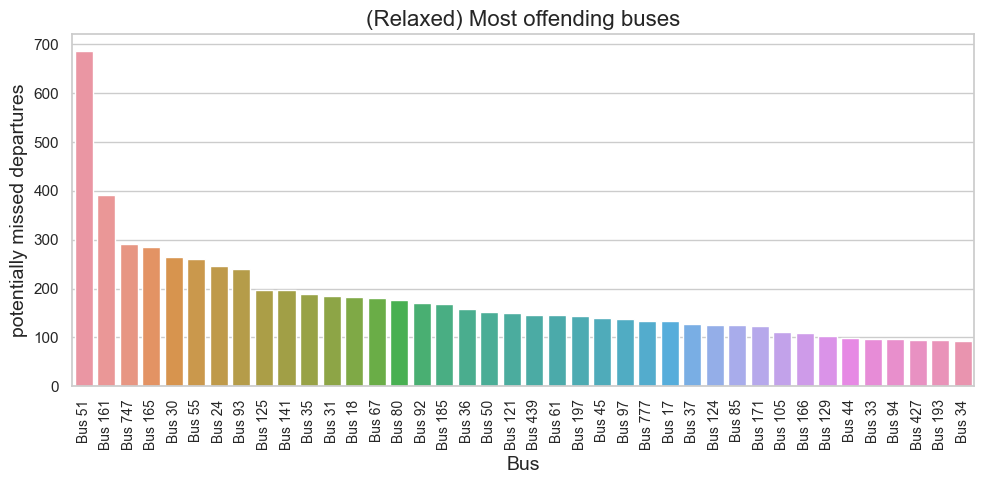

In [28]:
plt.figure(figsize=(10, 5))
sns.barplot(x='bus_route_short_name', y='count', data=bus_df_relaxed.sort_values('count', ascending=False).iloc[:40])

plt.title("(Relaxed) Most offending buses", fontsize=16)
plt.xlabel("Bus", fontsize=14)
plt.ylabel("potentially missed departures", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

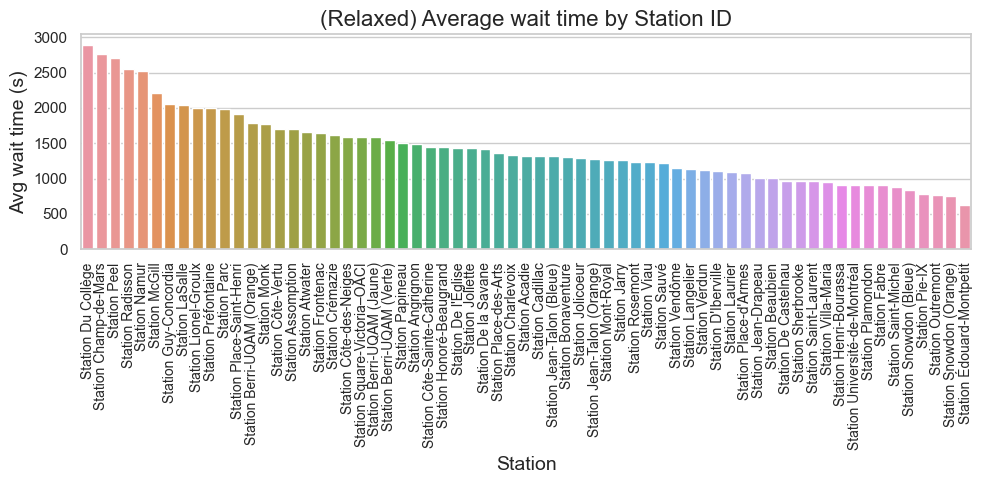

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(x='station_name', y='avg wait time (s)', data=proba_df_relaxed.sort_values('avg wait time (s)', ascending=False))

plt.title("(Relaxed) Average wait time by Station ID", fontsize=16)
plt.xlabel("Station", fontsize=14)
plt.ylabel("Avg wait time (s)", fontsize=14)

plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

### Testing per station

#### Get directions for route and first stop

In [30]:
ROUTE_TO_TEST = 18


In [31]:
def get_dir_first_stop_map(route_to_test, timetables=bus_timetables):
    stop_id_name_dict = dict(zip(stops['stop_id'], stops['stop_name']))
    calc_df = timetables[
        (timetables['route_short_name'] == route_to_test) & (timetables['stop_sequence'] == 1)
        ][['route_short_name', 'direction_id', 'stop_id']
    ].drop_duplicates(subset='direction_id')
    calc_df['stop_name'] = calc_df['stop_id'].map(stop_id_name_dict)
    dir_stop_dict = dict(zip(calc_df['direction_id'], calc_df['stop_name']))
    calc_df.rename(columns={'stop_name': 'first_stop_name'}, inplace=True)
    return calc_df, dir_stop_dict

##### Getting the directions for a bus

In [32]:
get_dir_first_stop_map(ROUTE_TO_TEST)[0]

,route_short_name,direction_id,stop_id,first_stop_name
10754,18.0,1,53275,Station Honoré-Beaugrand / Terminus Sud
80017,18.0,0,53851,Station Beaubien


In [33]:
#get_dir_first_stop_map(2, metro_timetables)[0]

In [34]:
def get_results_for_station_route_dir(proba, proba_daily_per_direction, station_name, metro_short_name, bus_short_name, direction_id):
    _, dir_stop_dict = get_dir_first_stop_map(bus_short_name)
    print("The probability at {} of missing Bus {} departing from {} is \033[1m{}\033[1m".format(
        station_name, bus_short_name, dir_stop_dict[direction_id], proba[station_name][bus_short_name, direction_id]
    ))
    plt.figure(figsize=(5, 3))
    plt.plot([(2*h+1) / 2 for h, _ in proba_daily_per_direction[station_name][bus_short_name, direction_id][0].keys()], proba_daily_per_direction[station_name][bus_short_name, direction_id][0].values(), marker='o', color='blue', linestyle='-')
    plt.plot([(2*h+1) / 2 for h, _ in proba_daily_per_direction[station_name][bus_short_name, direction_id][1].keys()], proba_daily_per_direction[station_name][bus_short_name, direction_id][1].values(), marker='o', color='orange', linestyle='-')
   
    plt.legend([METRO_DIRECTION_MAPPING[metro_short_name][0], METRO_DIRECTION_MAPPING[metro_short_name][1]])
    #plt.plot([(2*h+1) / 2 for h, _ in proba_daily_per_direction[station_name][route, direction_id].keys()], proba_daily_per_direction[station_name][route, direction_id].values(), marker='o', color='b', linestyle='-')
    plt.xlabel("Time of Day (Hours)")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.title("Probability of missing Bus {} \n departing from {} \n at {}".format(bus_short_name, dir_stop_dict[direction_id], station_name))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Rosemont

The probability at Station Rosemont of missing Bus 161 departing from Station Rosemont (Rosemont / De Saint-Vallier) is 0.3054


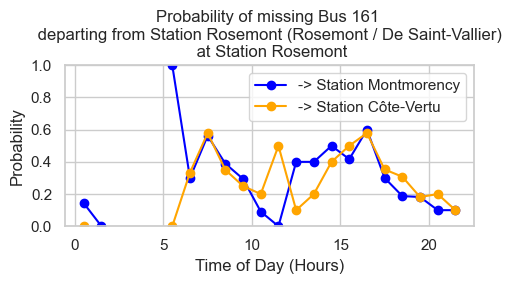

In [35]:
get_results_for_station_route_dir(
        proba_missing_per_station_bus_dir, daily_proba_missing_per_station_bus_dir_metro_dir, 'Station Rosemont', 2, 161, 1
)

It turns out, I was not unlucky at Rosemont. At some points of the day, I had a 60% chance of missing the bus if I did not exit the station in less than 3 minutes. Overall, I had a 30% chance of missing any 161 departure from Rosemont.

#### Place des Arts

The probability at Station Place-des-Arts of missing Bus 80 departing from Station Place-des-Arts (Président-Kennedy / Jeanne is 0.1797


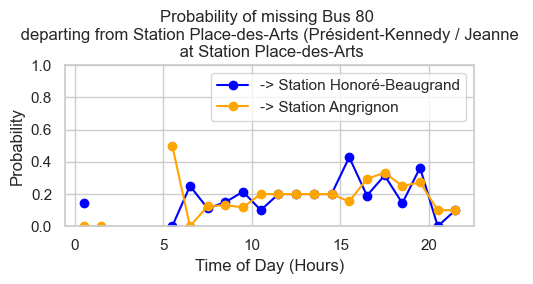

In [36]:
get_results_for_station_route_dir(
        proba_missing_per_station_bus_dir_relaxed, daily_proba_missing_per_station_bus_dir_metro_dir_relaxed, 'Station Place-des-Arts', 1, 80, 0
)

For Place des Arts, my luck gets worse. The probability that I miss the bus by design is mostly under 50% throughout the day.

#### Beaubien

The probability at Station Beaubien of missing Bus 18 departing from Station Honoré-Beaugrand / Terminus Sud is 0.303


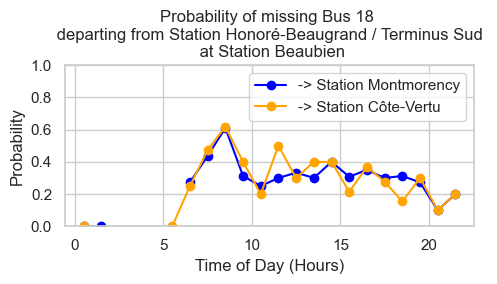

In [37]:
get_results_for_station_route_dir(
        proba_missing_per_station_bus_dir_relaxed, daily_proba_missing_per_station_bus_dir_metro_dir_relaxed, 'Station Beaubien', 2, 18, 1
)

The probability at Station Beaubien of missing Bus 160 departing from Station Beaubien (De Chateaubriand / Beaubien) is 0.1303


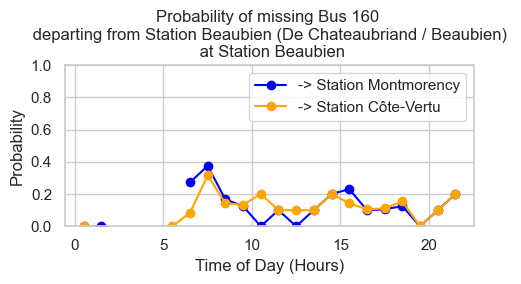

In [38]:
get_results_for_station_route_dir(
        proba_missing_per_station_bus_dir_relaxed, daily_proba_missing_per_station_bus_dir_metro_dir_relaxed, 'Station Beaubien', 2, 160, 1
)

##### One station example - for debugging purposes

{(0, 1): 0.5,
 (1, 2): 1.0,
 (2, 3): nan,
 (3, 4): nan,
 (4, 5): nan,
 (5, 6): 0.75,
 (6, 7): 0.6364,
 (7, 8): 0.7353,
 (8, 9): 0.7907,
 (9, 10): 0.7419,
 (10, 11): 0.7,
 (11, 12): 0.85,
 (12, 13): 0.5,
 (13, 14): 0.7,
 (14, 15): 0.7,
 (15, 16): 0.7778,
 (16, 17): 0.7632,
 (17, 18): 0.8108,
 (18, 19): 0.7,
 (19, 20): 0.7273,
 (20, 21): 0.4737,
 (21, 22): 0.4}

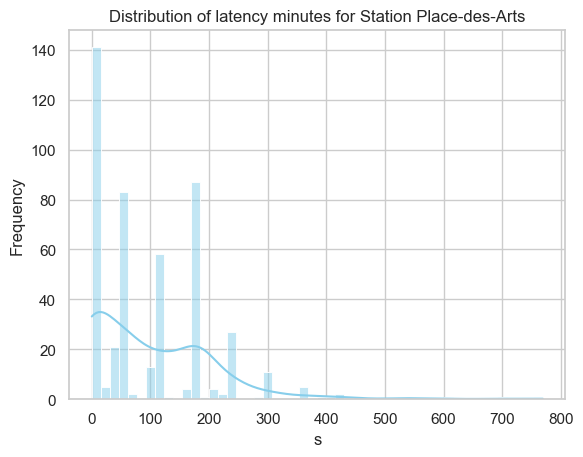

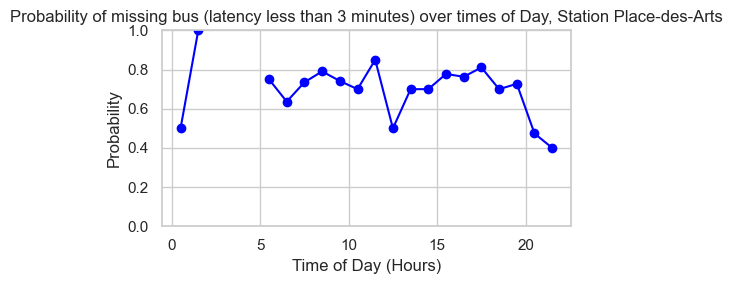

In [41]:
metro_stop_id = '31'
station_name = metro_stops[metro_stops['stop_id'] == metro_stop_id]['stop_name'].tolist()[0]
metro, bus, metro_bus_matches, metro_bus_match_bus_dir = get_time_diff_df_for_station(metro_stop_id, False)
plot_latency_distribution(metro_bus_matches, station_name)
get_proba_missing_bus(abs(metro_bus_matches['time_diff']))
get_proba_missing_bus_daily(metro_bus_matches, station_name)

### Tests

In [39]:
def test_match_bus_to_metro():
    """
    Only two stations don't pass the test, the examples refer to Square-Victoria, which do exist in the stop names
    """
    metro_to_bus_df = match_bus_to_metro(metro_stops, bus_stops)
    assert metro_to_bus_df.apply(lambda x: x['station name'].split('(')[0].strip() in x['stop name'], axis=1).sum() > 0.95 * len(metro_to_bus_df)

In [110]:
test_match_bus_to_metro()

In [40]:
def test_get_time_diff_df_for_station_Rosemont_161_1():
    _, _, _, metro_bus_match_per_bus_dir =  get_time_diff_df_for_station('7', restrict_to_first_stop=True)
    ### Double checked times in Citymapper
    metro_departure_time = datetime.strptime("2024-11-19 08:37:00", "%Y-%m-%d %H:%M:%S")
    closest_bus_departure_time = datetime.strptime("2024-11-19 08:41:00", "%Y-%m-%d %H:%M:%S")
    next_same_bus_departure = datetime.strptime("2024-11-19 08:51:00", "%Y-%m-%d %H:%M:%S")
    df = metro_bus_match_per_bus_dir[161, 1]
    assert df[df['metro_departure_time'] == metro_departure_time]['closest_bus_departure_time'].iloc[0] == closest_bus_departure_time
    assert df[df['metro_departure_time'] == metro_departure_time]['next_same_bus_departure'].iloc[0] == next_same_bus_departure

def test_get_time_diff_df_for_station_Beaubien_18_1():
    _, _, _, metro_bus_match_per_bus_dir =  get_time_diff_df_for_station('6', restrict_to_first_stop=True)
    assert metro_bus_match_per_bus_dir.get((18, 1)) is None
    assert metro_bus_match_per_bus_dir.get((160, 1)) is not None

    _, _, _, metro_bus_match_per_bus_dir =  get_time_diff_df_for_station('6', restrict_to_first_stop=False)
    ### Double checked times in Citymapper
    metro_departure_time = datetime.strptime("2024-11-19 08:38:00", "%Y-%m-%d %H:%M:%S")
    closest_bus_departure_time = datetime.strptime("2024-11-19 08:42:00", "%Y-%m-%d %H:%M:%S")
    next_same_bus_departure = datetime.strptime("2024-11-19 08:46:00", "%Y-%m-%d %H:%M:%S")
    df = metro_bus_match_per_bus_dir[18, 1]
    assert df[df['metro_departure_time'] == metro_departure_time]['closest_bus_departure_time'].iloc[0] == closest_bus_departure_time
    assert df[df['metro_departure_time'] == metro_departure_time]['next_same_bus_departure'].iloc[0] == next_same_bus_departure


In [112]:
test_get_time_diff_df_for_station_Rosemont_161_1()
test_get_time_diff_df_for_station_Beaubien_18_1()